##### A Model Which Incorporates Keywords

In [33]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot  as plt
import os 

In [19]:
cwd = os.getcwd()
print(cwd)

/Users/gkhan/Documents/GitHub/may-2024-mental-health-nlp/Gabe's_notebooks/models


### Importing the data

In [65]:
df_coded = pd.read_csv('../data/processed_and_coded_posts.csv')

Now we will import the keywords

In [66]:
csv_file_path = '../keywords/medications.csv'

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Extract the first column as a list of keywords
medications = df.iloc[:, 0].tolist()

In [75]:
csv_file_path_2 = '../keywords/Treatment.csv'

# Read the CSV file
df_2 = pd.read_csv(csv_file_path_2)

# Extract the first column as a list of keywords
therapy = df_2.iloc[:, 0].tolist()

In [98]:
general_keywords = ['medicine','therapy','treatment','recovery','prescribed','diagnosed','med','meds','prescribe','therapist','session','psychiatrist','psychiatrists','dosage','medication', 'dbt', 'abilify', 'outpatient', 'therapist', 'harming','medicine','therapy','treatment','recovery','prescribed','diagnosed','therapists','prescribe','diagnose','medicines','drugs','drug','therapist','session']

In [99]:
len(general_keywords)

34

### Code to count keywords

In [48]:
def count_keywords(text, keywords):
    return sum(text.lower().split().count(keyword) for keyword in keywords)


In [67]:
df_coded.processed_text.count()

600

In [8]:
df_coded.head()

,title,selftext,created_utc,over_18,subreddit,date_created,self,is_relevant,highly_relevant,combined_text,processed_text
0,Living with BPD,"hi all, not sure if this is ok to post so plea...",1643066256,False,BPD,2022-01-24 23:17:36,0,0,0,"Living with BPD hi all, not sure if this is ok...","living bpd hi all, sure ok post please remove ..."
1,i feel like i’m losing my battle and nothings ...,i’ve struggled with depression since i was abo...,1643064417,False,BPD,2022-01-24 22:46:57,1,0,0,i feel like i’m losing my battle and nothings ...,feel like i’m losing battle nothing helping i’...
2,The Way Social Media Assumes Things About and ...,like i’m a rare case of bpd developing at a ve...,1643064326,False,BPD,2022-01-24 22:45:26,1,0,0,The Way Social Media Assumes Things About and ...,way social medium assumes thing portraying bpd...
3,How to cope with family who doesn’t believe in...,i have been diagnosed with bpd late 2020s and ...,1643062602,False,BPD,2022-01-24 22:16:42,1,0,0,How to cope with family who doesn’t believe in...,cope family doesn’t believe mental illness dia...
4,Lost my FP/partner and now I’m addicted to dat...,my partner and fp broke up with me about 2 wee...,1643061431,False,BPD,2022-01-24 21:57:11,1,0,0,Lost my FP/partner and now I’m addicted to dat...,lost fp/partner i’m addicted dating apps hopin...


In [100]:
df_coded['medication_count'] = df_coded['processed_text'].apply(lambda x: count_keywords(x, medications))
df_coded['general_count'] = df_coded['processed_text'].apply(lambda x: count_keywords(x, general_keywords))
df_coded['therapy_count'] = df_coded['processed_text'].apply(lambda x: count_keywords(x, therapy))


In [101]:
df_coded['meds_plus_therapy'] = df_coded['medication_count']+df_coded['therapy_count']
df_coded['all_keywords'] = df_coded['medication_count']+df_coded['therapy_count']+df_coded['general_count']

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


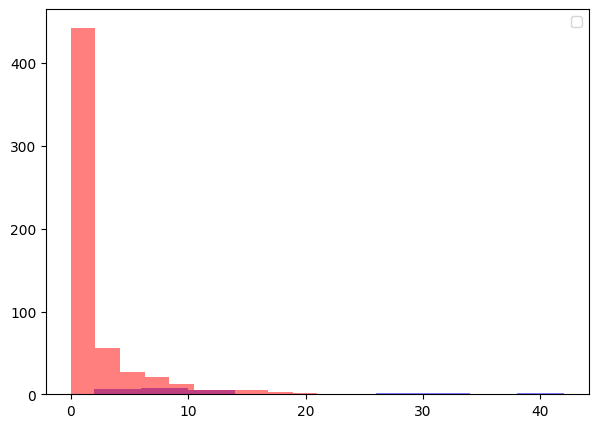

In [105]:
plt.figure(figsize=(7,5))

plt.hist(df_coded[df_coded['highly_relevant']==1].all_keywords, color = 'b',alpha=0.5)
plt.hist(df_coded[df_coded['highly_relevant']==0].all_keywords, color = 'r',alpha=0.5)

plt.legend(fontsize=10)



plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


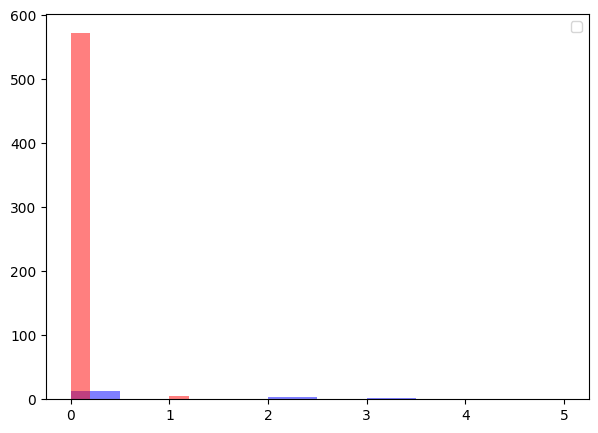

In [107]:
plt.figure(figsize=(7,5))

plt.hist(df_coded[df_coded['highly_relevant']==1].medication_count, color = 'b',alpha=0.5)
plt.hist(df_coded[df_coded['highly_relevant']==0].medication_count, color = 'r',alpha=0.5)

plt.legend(fontsize=10)



plt.show()

#### EDA

Mentioning a medication is a very strong signal that a post is relevant.

The therapy keywords are not doing a great job right now, but the presence of a keyword is a very strong signal. Maybe by refining the keywords, we can build a better model.

Perhaps we should only consider posts which contain a set of minimal keywords, and then build a model from there. This is a natural place to use decision trees and forests. I'm not sure how to turn the text post into a usable collection of attributes, but I'll try to think about this

In [108]:
count_missing = ((df_coded.highly_relevant == 0) & (df_coded.all_keywords > 0)).sum()
print(count_missing)

217


In [89]:
keyword_misses = ((df_coded.highly_relevant == 1) & (df_coded.meds_plus_therapy ==0))

filtered_df = df_coded[keyword_misses]

filtered_df.to_csv('../data/keyword_misses.csv')

### Trying to make a model

THIS IS UNDER PROGRESS, AND WON'T COMPILE

In [ ]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report




In [ ]:
# Custom transformer to extract the keyword count feature
class KeywordCountExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, keywords):
        self.keywords = keywords

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([count_keywords(text, self.keywords) for text in X]).reshape(-1, 1)

# Define the combined feature union 
    ###To do: Update the counts
combined_features = FeatureUnion([
    ('tfidf', TfidfVectorizer()),
    ('keyword_count', Pipeline([
        ('extract', FunctionTransformer(lambda x: x, validate=False)),
        ('count', KeywordCountExtractor(keywords))
    ]))
])

# Create the pipeline with combined features and the classifier
pipeline = Pipeline([
    ('features', combined_features),
    ('classifier', MultinomialNB())
])

# Split the data into features and target variable
# To do: Update the model to incorporate the keyword counts
X = df_coded['processed_text']
y = df_coded['highly_relevant']

# Perform k-fold cross-validation on the training set
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store evaluation results
all_train_reports = []
all_holdout_reports = []

# Perform k-fold cross-validation
for train_index, holdout_index in kfold.split(X, y):
    X_train, X_holdout = X.iloc[train_index], X.iloc[holdout_index]
    y_train, y_holdout = y.iloc[train_index], y.iloc[holdout_index]
    
    # Train the model on the training set
    pipeline.fit(X_train, y_train)
    
    # Evaluate the model on the training set
    y_pred_train = pipeline.predict(X_train)
    train_report = classification_report(y_train, y_pred_train, output_dict=True)
    all_train_reports.append(train_report)
    
    # Evaluate the model on the hold-out set
    y_pred_prob_holdout = pipeline.predict_proba(X_holdout)[:, 1]  # Get probabilities for the positive class
    
    # Adjust the threshold
    threshold = 0.3  # Example threshold less than 0.5 to increase sensitivity
    y_pred_holdout = (y_pred_prob_holdout >= threshold).astype(int)
    
    holdout_report = classification_report(y_holdout, y_pred_holdout, output_dict=True)
    all_holdout_reports.append(holdout_report)
    
    # Filter the holdout set for entries predicted as positive
    positive_entries = X_holdout[y_pred_holdout == 1]
    
    # Display the positive entries from the holdout set
    print("\nEntries from the holdout set that the model predicted as positive:")
    print(positive_entries)
    
    # Additionally, show the actual labels for these entries
    positive_labels = y_holdout[y_pred_holdout == 1]
    print("\nActual labels for the positive entries:")
    print(positive_labels)

# Print average classification reports for train and holdout sets
avg_train_report = pd.DataFrame(all_train_reports).mean().to_dict()
avg_holdout_report = pd.DataFrame(all_holdout_reports).mean().to_dict()

print("\nAverage classification report on the training set:")
print(avg_train_report)

print("\nAverage classification report on the holdout set:")
print(avg_holdout_report)
